In [1]:
#import sys
#!{sys.executable} -m pip install scikit-learn
#!{sys.executable} -m pip install numpy==0.21.3
#!{sys.executable} -m pip install --upgrade pip

import numpy as np
import matplotlib.pyplot as plt
from utils import mnist_reader, helper
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from scipy.sparse.linalg import eigsh
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# for reproducibility, use rs to generate all random quantities
rs = np.random.RandomState(10012020)


X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

#preprocessing
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

#Some code from an in class example
templatedims = 4
templates = rs.randn(10, templatedims)
templates = templates / np.linalg.norm(templates, axis=1, ord=2).reshape(10,1)

def encode_target(y):
    return templates[y]

def recover_target(y):
    diffs = templates - np.repeat(y.reshape(1,templatedims), 10, axis=0)
    dists = np.sum(diffs * diffs, axis=1)
    return np.argmin(dists)

Y_train = np.array([encode_target(y) for y in y_train], dtype=float)
Y_test =  np.array([encode_target(y) for y in y_test], dtype=float)

n_train, d = X_train.shape

In [6]:
def f(X, Y, W):
    return 1/2*np.linalg.norm(Y - X @ W)**2

def grad(X, Y, W):
    Hess = X.T @ X
    projY = X.T @ Y
    return Hess @ W - projY


def ADAM(X, Y, W, T, a, beta1, beta2, eps):
    Wcurr = W
    eta = 1.0
    m = np.zeros((784, 4))
    v = np.zeros((784, 4))
    weights = []
    for i in range(T):
        eta = 1.0/(1.0+a*i)
        index = np.random.choice(X.shape[0], 1, replace=False) #get random index
        gt = grad(X[index], Y[index], Wcurr)
        
        m = beta1*m+(1-beta1)*gt
        v = v-(1-beta2)*(v-gt**2)
        Wcurr = Wcurr-(eta*m)/(v**0.5+eps)
        weights.append(Wcurr)
    return weights


def YOGI(X, Y, W, T, a, beta1, beta2, eps):
    Wcurr = W
    eta = 1.0
    m = np.zeros((784, 4))
    v = np.zeros((784, 4))
    weights = []
    for i in range(T):
        eta = 1.0/(1.0+a*i)
        index = np.random.choice(X.shape[0], 1, replace=False) #get random index
        gt = grad(X[index], Y[index], Wcurr)
        
        m = beta1*m+(1-beta1)*gt
        v = v-(1-beta2)*np.sign(v-gt**2)*gt**2
        Wcurr = Wcurr-(eta*m)/(v**0.5+eps)
        weights.append(Wcurr)
    return weights

def AdaGrad(X, Y, W, T, eta, eps):
    Wcurr = W
    weights = []
    v = 0.0
    for i in range(T):
        index = np.random.choice(X.shape[0], 1, replace=False) #get random index
        gt = grad(X[index], Y[index], Wcurr)
        v = v+gt**2
        Wcurr = Wcurr - eta/(v + eps)**0.5 * gt
        weights.append(Wcurr)
    return weights
        



In [7]:
W = np.zeros((d, templatedims))
beta1 = 0.9
beta2 = 0.999
adagrad_eta = 0.1
eps = 10**(-8)
T = 1000
a=0.1
ADAM_weights = ADAM(X_train, Y_train, W, T, a, beta1, beta2, eps)
YOGI_weights = YOGI(X_train, Y_train, W, T, a, beta1, beta2, eps)
AdaGrad_weights = AdaGrad(X_train, Y_train, W, T, adagrad_eta, eps)
print("Ran ADAM and YOGI And AdaGrad")
ADAM_loss = []
YOGI_loss = []
AdaGrad_loss = []

for i in range(T):
    ADAM_loss.append(f(X_train, Y_train, ADAM_weights[i]))
    YOGI_loss.append(f(X_train, Y_train, YOGI_weights[i]))
    AdaGrad_loss.append(f(X_train, Y_train, AdaGrad_weights[i]))

Ran ADAM and YOGI


In [4]:
# def get_accuracy(X, Y, W):
#     learned_labels = X@W
#     tot = 0
#     for i in range(len(Y)):
#         if recover_target(Y[i]) == recover_target(learned_labels[i]):
#             tot += 1
#     return tot/len(Y)
        
# train_acc = []
# test_acc = []  
# for i in range(400):
#     W = ADAM_weights[i]
#     train_acc.append(get_accuracy(X_train, Y_train, W))
#     test_acc.append(get_accuracy(X_test, Y_test, W))


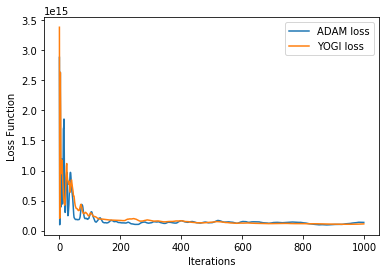

In [8]:
plt.plot(range(T), ADAM_loss, label="ADAM loss")
plt.plot(range(T), YOGI_loss, label="YOGI loss")

plt.legend()
#plt.xlim([0, 200])
plt.xlabel("Iterations")
plt.ylabel("Loss Function")
plt.show()


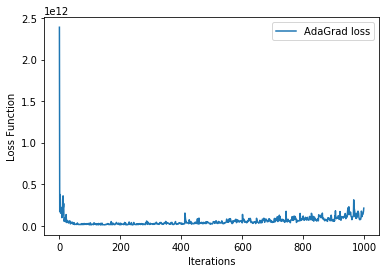

In [9]:
plt.plot(range(T), AdaGrad_loss, label="AdaGrad loss")

plt.legend()
#plt.xlim([0, 200])
plt.xlabel("Iterations")
plt.ylabel("Loss Function")
plt.show()